In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, dstn, idstn, fftshift, ifftshift

from classicalfield_orig import FiniteTempGPE as gpe 

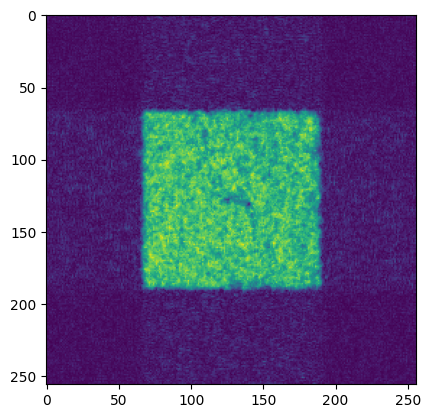

In [9]:
imported_data = np.loadtxt('vortexout.csv', dtype = np.complex_)
plt.imshow(np.abs(imported_data))

In [7]:
print(100/(0.0007/5))

714285.7142857143


In [11]:
print(1000/g.gpeobj.dt)

2621440.0


Total Imag Time:  2.268876791000366
kmax:  8.042477193189871
T:  3.2340719701489613


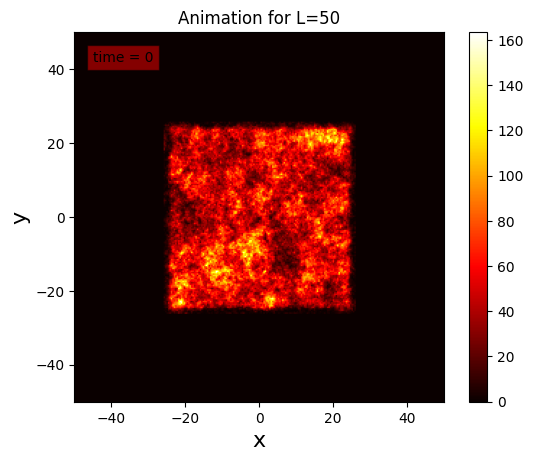

In [2]:
g = gpe(npoints = 2**7, vortex = True, numRealSteps = 100000, Nsamples = 1, runAnim = True, animFileName = 'vortextest_tracking.mp4', Tfact = 1/10, dst = False, dtcoef = 0.0025)

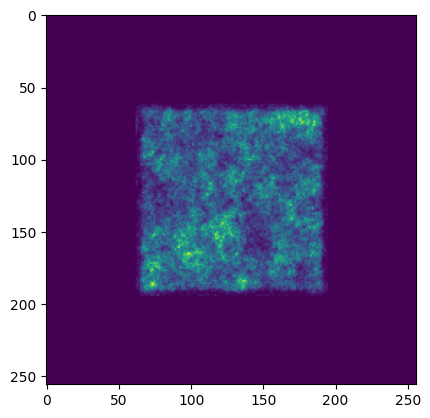

In [3]:
plt.figure() 
plt.imshow(np.abs(g.snaps[0])**2)

In [277]:
def detect_vortices2(psi, dx, L):
    '''
    Detect vortex positions by checking for 2π phase windings around plaquettes.

    Parameters:
    psi - complex wavefunction (2D array)
    dx - grid spacing

    Returns:
    vortex_positions - list of (x, y) tuples (in index or physical coords)
    '''
    #sideL = len(psi) 
    psi = psi[int(L/2/dx):int(3*L/2/dx), int(L/2/dx):int(3*L/2/dx)]
    plt.figure() 
    plt.imshow(np.abs(psi)**2)
    plt.colorbar() 
    plt.show() 
    phase = np.angle(psi)
    Ny, Nx = phase.shape
    vortex_positions = []

    for i in range(1, Ny - 2):
        for j in range(1, Nx - 2):
            # Get the 2x2 plaquette phase values (counter-clockwise order)
            phi = [phase[i, j], phase[i, j+1], phase[i+1, j+1], phase[i+1, j]]

            # Compute phase differences around the plaquette
            dphi = np.diff(phi + [phi[0]])  # loop around
            dphi = np.mod(dphi + np.pi, 2 * np.pi) - np.pi  # wrap to [-π, π]

            winding_number = np.sum(dphi) / (2 * np.pi)

            psi_dens = np.abs(psi)**2 
            threshold = 0
            if np.abs(winding_number) > 0.9 and np.min([psi_dens[i,j], psi_dens[i,j+1], psi_dens[i+1,j], psi_dens[i+1,j+1]]) > threshold:  # threshold to count as a vortex
                #  and -np.abs(psi[i,j]) > -5 and np.min([psi_dens[i,j], psi_dens[i,j+1], psi_dens[i+1,j], psi_dens[i+1,j+1]]) > threshold 
                # Estimate vortex center (you can interpolate better later)
                # print([psi_dens[i,j], psi_dens[i,j+1], psi_dens[i+1,j], psi_dens[i+1,j+1]])
                # print(i) 
                # print(j) 
                
                x = j + 0.5
                y = i + 0.5
                # print(x)
                # print(y)
                if x*dx > 7*dx/2 and y*dx > 7*dx/2 and x*dx < L-7*dx/2 and y*dx < L-7*dx/2:
                    vortex_positions.append((x * dx, y * dx))

    

    return vortex_positions

In [549]:
def detect_vortices(psi, dx, L, previous_vortices=None, margin=10):
    '''
    Detect vortex positions by checking for 2π phase windings around plaquettes.
    Searches only within a region of interest around previous vortices.

    Parameters:
    psi - complex wavefunction (2D array)
    dx - grid spacing
    L - box length
    previous_vortices - list of (x, y) vortex positions in physical coordinates
    margin - number of grid points around previous vortex region to include

    Returns:
    vortex_positions - list of (x, y) tuples in physical coordinates
    '''
    psi = psi[int(L/2/dx):int(3*L/2/dx), int(L/2/dx):int(3*L/2/dx)] # keep the box only within the potential walls 
    Ny, Nx = psi.shape
    phase = np.angle(psi)
    vortex_positions = []

    # Convert physical positions to indices
    if previous_vortices is None or len(previous_vortices) == 0:
        # Search the entire domain if no previous positions are given
        i_min, i_max = 1, Ny - 2
        j_min, j_max = 1, Nx - 2
    else:
        i_indices = []
        j_indices = []
        for x, y in previous_vortices:
            j_indices.append(int(x / dx))
            i_indices.append(int(y / dx))

        i_min = max(1, min(i_indices) - margin)
        i_max = min(Ny - 2, max(i_indices) + margin)
        j_min = max(1, min(j_indices) - margin)
        j_max = min(Nx - 2, max(j_indices) + margin)

    # Main vortex detection loop
    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            phi = [phase[i, j], phase[i, j+1], phase[i+1, j+1], phase[i+1, j]]
            dphi = np.diff(phi + [phi[0]])
            dphi = np.mod(dphi + np.pi, 2 * np.pi) - np.pi
            winding_number = np.sum(dphi) / (2 * np.pi)

            psi_dens = np.abs(psi)**2
            threshold = 0.0 # Adjust if needed
            
            if np.abs(winding_number) > 0.95 and np.min([psi_dens[i,j], psi_dens[i,j+1], psi_dens[i+1,j], psi_dens[i+1,j+1]]) > threshold:
                #print([psi_dens[i,j], psi_dens[i,j+1], psi_dens[i+1,j], psi_dens[i+1,j+1]])
                x = (j + 0.5) * dx
                y = (i + 0.5) * dx
                vortex_positions.append((x, y))
    # vortex_positions can become the next previous_vortices 
    #pos_arr = np.array(vortex_positions)

    clustered_positions = cluster_vortices(vortex_positions, threshold = dx)
    #return vortex_positions
    return clustered_positions


In [544]:
from itertools import combinations

In [550]:
# fix this function? 

def cluster_vortices(vortex_positions,threshold = 1):
    '''
    
    '''

    if len(vortex_positions) == 0: 
        return [] 
    pos_array = np.array(vortex_positions) 
    clusters = [] 

    used_ind = set() 

    for i, pos in enumerate(pos_array): 
        if i in used_ind: 
            continue 
        cluster = [pos] 
        used_ind.add(i) 
    

        for j, other_pos in enumerate(pos_array): 
        
            if j in used_ind: 
                continue 
            # print("Distance: ", np.abs(pos[0] - other_pos[0])**2 + np.abs(pos[1] - other_pos[1])**2)
            # print("v1: ", pos)
            # print("v2: ", other_pos)
            
            if np.sqrt(np.abs(pos[0] - other_pos[0])**2 + np.abs(pos[1] - other_pos[1])**2) < threshold:

                cluster.append(other_pos) 
                used_ind.add(j) 


        cluster_mean = np.mean(cluster, axis = 0) 

        clusters.append(tuple(cluster_mean))
    if len(clusters) > 2: 
        max_dist = 0
        max_pair = (None, None)
        for c1, c2 in combinations(clusters, 2): 
            curr_dist =  np.sqrt(np.abs(c1[0] - c2[0])**2 + np.abs(c1[1] - c2[1])**2)
            if curr_dist > max_dist: 
                max_dist = curr_dist
                max_pair = [c1, c2]

        clusters = max_pair
    return clusters  

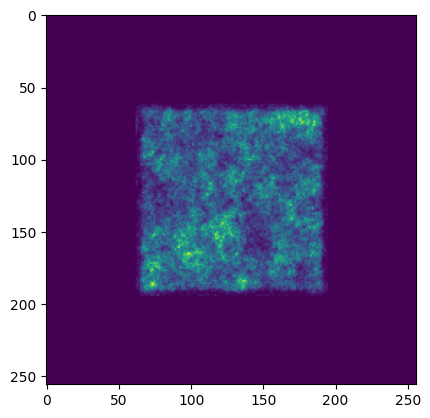

In [486]:
plt.figure()
plt.imshow(np.abs(g.snaps[0])**2)

In [552]:
prev_pos = None 
prev_pos = detect_vortices(g.snaps[0], g.dx, g.L)
print("THRESHOLD: ", g.dx*4)
vortex_positions = []
#for i in range(len(g.snaps)): 
for i in range(100, 200): 
    print(i)
    vortex_pos = detect_vortices(g.snaps[i], g.dx, g.L, prev_pos)
    prev_pos = vortex_pos  
    
    print("Vortex Locations: ", vortex_pos)
    vortex_positions.append(np.array([vortex_pos[0][0], vortex_pos[0][1], vortex_pos[1][0], vortex_pos[1][1]])) 
    # if i%50 ==0: 
    #     print(vortex_pos)
vortex_positions = np.array(vortex_positions) 

## how to resolve the fact that in some occassions its catching multiple vortices in the same spot? 

THRESHOLD:  1.5625
100
Vortex Locations:  [(25.9765625, 22.8515625), (29.1015625, 27.5390625)]
101
Vortex Locations:  [(25.9765625, 22.8515625), (29.1015625, 27.5390625)]
102
Vortex Locations:  [(25.9765625, 22.8515625), (29.1015625, 27.5390625)]
103
Vortex Locations:  [(26.3671875, 22.8515625), (29.1015625, 27.5390625)]
104
Vortex Locations:  [(26.3671875, 22.8515625), (29.1015625, 27.1484375)]
105
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.5390625)]
106
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.5390625)]
107
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.5390625)]
108
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.9296875)]
109
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.9296875)]
110
Vortex Locations:  [(25.9765625, 22.4609375), (28.7109375, 27.9296875)]
111
Vortex Locations:  [(25.9765625, 22.4609375), (29.1015625, 27.9296875)]
112
Vortex Locations:  [(25.5859375, 22.4609375), (29.1015625, 27.929

In [502]:
print(29.1015625/g.dx)

74.5


3.5


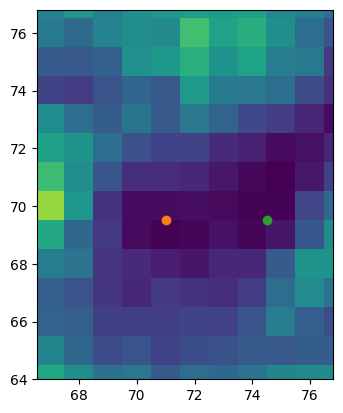

In [525]:
plt.figure() 
plt.imshow(np.abs(g.snaps[151][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx):int(3*g.L/2/g.dx)])**2, origin = 'lower')
plt.scatter(26.7578125/g.dx, 22.8515625/g.dx)
plt.scatter(27.734375/g.dx, 27.1484375/g.dx)
plt.scatter(29.1015625/g.dx, 27.1484375/g.dx)

plt.ylim(25/g.dx, 30/g.dx)
plt.xlim(26/g.dx,30/g.dx)
# print(np.abs(g.xi[0][0][int(29.1015625/g.dx+0.5)] - g.xi[0][0][int(27.734375/g.dx+0.5)])**2)

print((29.1015625/g.dx-27.734375/g.dx))


In [460]:
print(np.abs(27.734375-29.1015625)**2 +np.abs(27.1484375-27.1484375)**2 )

1.86920166015625


In [400]:
print(len(g.snaps[5])//2)
print(int(g.L/2/g.dx)+vortex_positions[5]/g.dx)
print(vortex_positions[5])

print(np.abs(g.snaps[5][int(25.1953125/g.dx-0.5+64)][int(24.8046875/g.dx-0.5+64)])**2)

128
[127.5 128.5 135.5 128.5]
[24.8046875 25.1953125 27.9296875 25.1953125]
0.02990905309403402


(0.0, 1.0)

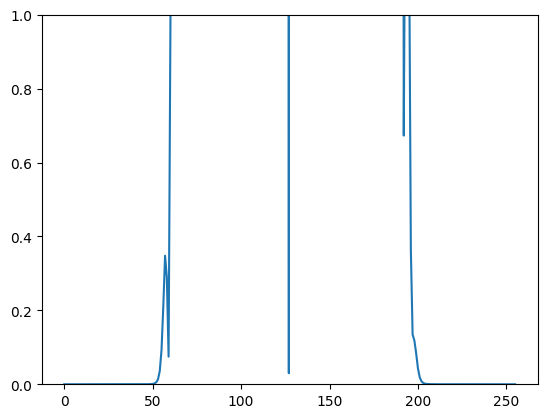

In [403]:
plt.figure() 
plt.plot(np.abs(g.snaps[5][int(25.1953125/g.dx-0.5+64)])**2)
plt.ylim(0,1)

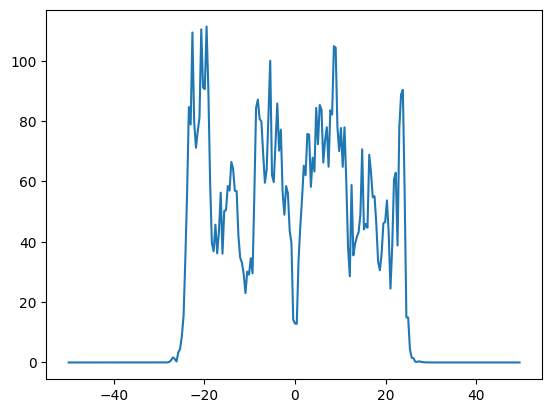

In [380]:
plt.figure() 
plt.plot(g.xi[0][0], np.abs(g.snaps[5][:,128])**2)


In [437]:
print(np.abs(26.3671875 - 26.7578125)**2 + np.abs( 22.265625-22.8515625)**2)
print(g.dx*1.5)

0.49591064453125
0.5859375


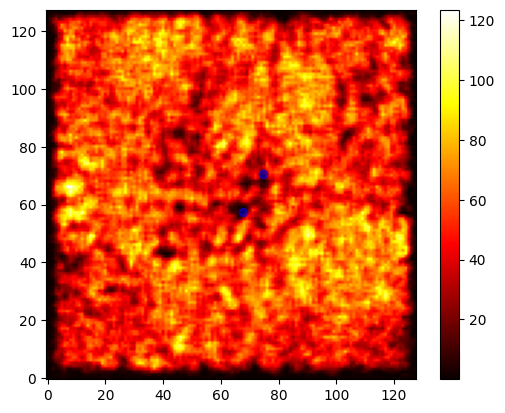

In [479]:
snap = 125
psi = np.abs(g.snaps[snap][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx):int(3*g.L/2/g.dx)])**2
vortex_ind = vortex_positions[snap]

plt.figure() 
plt.imshow(psi, origin = 'lower', cmap = plt.cm.hot)
plt.colorbar() 
#for i in range(len(vortex_pos)): 
    #if vortex_pos[i][0] != g.dx/2 and vortex_pos[i][1] != g.dx/2 and vortex_pos[i][0] != g.L-3*g.dx/2 and vortex_pos[i][1] != g.L-3*g.dx/2:
    # if vortex_pos[i][0] > 7*g.dx/2 and vortex_pos[i][1] > 7*g.dx/2 and vortex_pos[i][0] < g.L-7*g.dx/2 and vortex_pos[i][1] < g.L-7*g.dx/2:
    #     plt.scatter(vortex_pos[i][0]/g.dx, vortex_pos[i][1]/g.dx, alpha = 1, color = 'red') 


plt.scatter(vortex_ind[0]/g.dx, vortex_ind[1]/g.dx, alpha = 0.5, color = 'blue') 
plt.scatter(vortex_ind[2]/g.dx, vortex_ind[3]/g.dx, alpha = 0.5, color = 'blue') 

# TODO plot the points where the vortex is present at index 125 of snaps
# [(26.3671875, 22.265625), (26.7578125, 22.8515625), (29.1015625, 27.5390625)]
# plt.scatter(26.3671875/g.dx, 22.265625/g.dx)
# plt.scatter(29.1015625/g.dx, 27.5390625/g.dx)
# plt.scatter(26.7578125/g.dx, 22.8515625/g.dx, color = 'green')
# #plt.scatter(29.1015625/g.dx, 27.5390625/g.dx, color = 'blue')
# plt.xlim(25/g.dx, 27/g.dx)
# plt.ylim(21/g.dx, 23/g.dx)
plt.show() 

Text(0, 0.5, 'Vortex Distance')

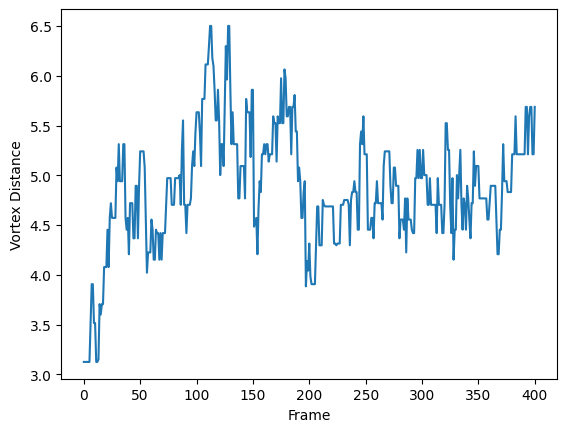

In [480]:
dist = np.sqrt(np.abs(vortex_positions[:,0]-vortex_positions[:,2])**2 + np.abs(vortex_positions[:,1]-vortex_positions[:,3])**2) 
plt.figure() 
plt.plot(np.arange(0, len(g.snaps)), dist)
plt.xlabel('Frame')
plt.ylabel('Vortex Distance')

C:\Users\TQC User\AppData\Local\Temp\ipykernel_11464\3091135994.py:1: RuntimeWarning: divide by zero encountered in divide
  ang = np.arctan((vortex_positions[:,1]-vortex_positions[:,3])/(vortex_positions[:,0] - vortex_positions[:,2]))


Text(0, 0.5, 'Vortex Angle (rad)')

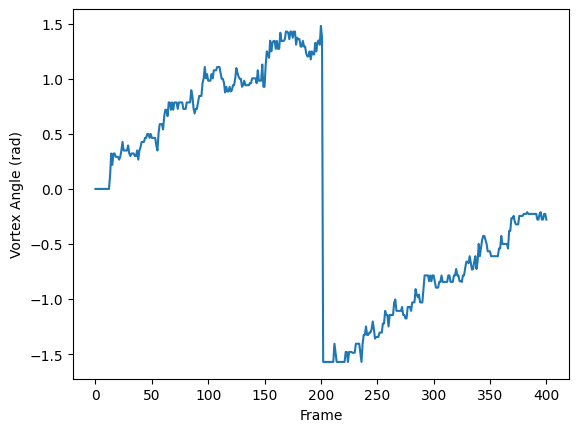

In [481]:
ang = np.arctan((vortex_positions[:,1]-vortex_positions[:,3])/(vortex_positions[:,0] - vortex_positions[:,2]))
plt.figure() 
plt.plot(np.arange(0, len(g.snaps)), ang)
plt.xlabel('Frame')
plt.ylabel('Vortex Angle (rad)')

In [187]:
psi = np.abs(g.snaps[snap][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx):int(3*g.L/2/g.dx)])**2

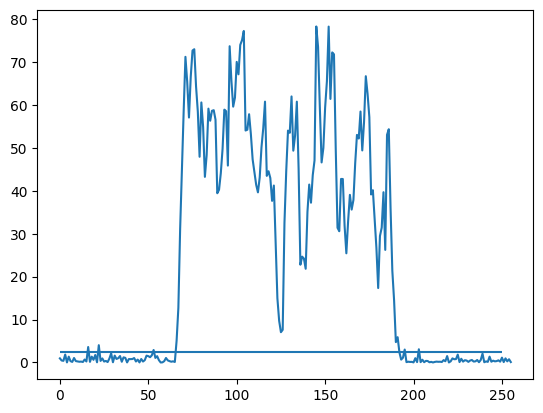

In [150]:
plt.figure() 
plt.plot(np.abs(g.snaps[-1][len(g.snaps[-1])//2])**2)
#plt.ylim(0,20)
plt.hlines(2.5, 0, 250)

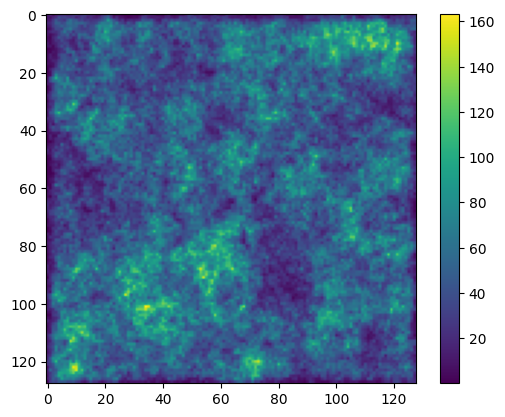

(2, 2)
[(24.8046875, 25.1953125), (27.9296875, 25.1953125)]


In [279]:
# test out the tracking feature 
snap = 0

vortex_pos = detect_vortices(g.snaps[snap], g.dx, g.L) 
print(np.shape(vortex_pos))
print(vortex_pos)

# for i in range(len(vortex_pos)): 
#     if vortex_pos[i][0] != g.dx/2 and vortex_pos[i][1] != g.dx/2: 
#         print(vortex_pos[i])

In [228]:
1.75/g.dx

4.48

118.5
8.274881


(0.0, 5.0)

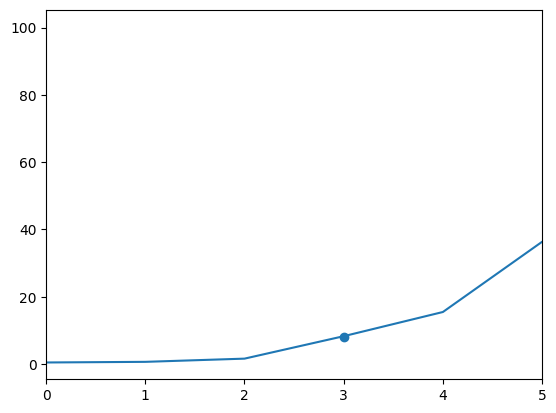

In [197]:
print(46.2890625/g.dx)
print(psi[118,3])

plt.figure() 
plt.plot(psi[118])
plt.scatter(3,8)
plt.xlim(0,5)

In [255]:
print(vortex_pos)

[(26.7578125, 21.6796875), (27.1484375, 25.9765625), (48.2421875, 30.2734375)]


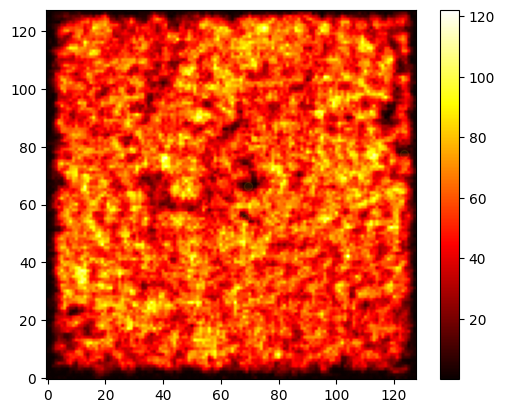

In [270]:
psi = np.abs(g.snaps[snap][int(g.L/2/g.dx):int(3*g.L/2/g.dx), int(g.L/2/g.dx):int(3*g.L/2/g.dx)])**2

plt.figure() 
plt.imshow(psi, origin = 'lower', cmap = plt.cm.hot)
plt.colorbar() 
for i in range(len(vortex_pos)): 
    #if vortex_pos[i][0] != g.dx/2 and vortex_pos[i][1] != g.dx/2 and vortex_pos[i][0] != g.L-3*g.dx/2 and vortex_pos[i][1] != g.L-3*g.dx/2:
    # if vortex_pos[i][0] > 7*g.dx/2 and vortex_pos[i][1] > 7*g.dx/2 and vortex_pos[i][0] < g.L-7*g.dx/2 and vortex_pos[i][1] < g.L-7*g.dx/2:
    #     plt.scatter(vortex_pos[i][0]/g.dx, vortex_pos[i][1]/g.dx, alpha = 1, color = 'red') 
    plt.scatter(vortex_pos[i][0]/g.dx, vortex_pos[i][1]/g.dx, alpha = 0.1, color = 'orange') 

#plt.scatter(2/g.dx, 21/g.dx, color = 'red')
# plt.ylim(22/g.dx, 28/g.dx)
# plt.xlim(25/g.dx, 29/g.dx)
plt.show() 

In [4]:
## Figure out what dt is relative to T, kmax, and V 

In [4]:
print("Temperature: ", g.T)
# KE ~ 32 
print("dt: ", g.gpeobj.dt)
print("PE: ", np.max(g.gpeobj.Vbox))
# Eventually increase V once you can reproduce earlier results in the other file 
print("KE: ", (np.pi/g.dx)**2/2)
print("Interaction Energy: " , g.gpeobj.g * 50)
print("Total Time: ", g.gpeobj.dt * 264000)
print("Number of Atoms", g.gpeobj.Natoms)

Temperature:  3.2340719701489613
dt:  0.0003814697265625
PE:  10.0
KE:  32.34071970148961
Interaction Energy:  0.9765625
Total Time:  100.7080078125
Number of Atoms 128000


In [13]:
print(g.gpeobj.dt * 50000)

38.14697265625


In [8]:
saved_file = np.savetxt('vortexout.csv', g.snaps[-1])

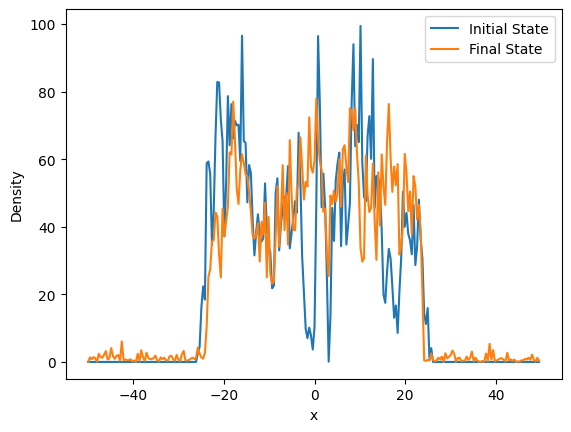

In [5]:
plt.figure() 
plt.plot(g.xi[0][0], np.abs(g.snaps[0])[len(g.snaps[0])//2]**2, label = 'Initial State')
plt.plot(g.xi[0][0], np.abs(g.snaps[-1])[len(g.snaps[-1])//2]**2, label = 'Final State')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

In [41]:
print(np.sum(np.abs(g.snaps[0])**2)*g.dx**2)
print(np.sum(np.abs(g.snaps[-1])**2)*g.dx**2)

128000.0
128000.0


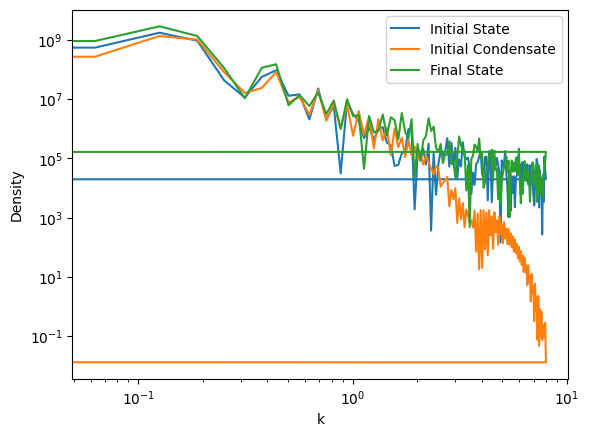

In [6]:
plt.figure() 
plt.plot(g.ki[0][0], np.abs(fft2(g.snaps[0]))[0]**2, label = 'Initial State')
plt.plot(g.ki[0][0], np.abs(fft2(g.gs))[0]**2, label = 'Initial Condensate')
plt.plot(g.ki[0][0], np.abs(fft2(g.snaps[-1]))[0]**2, label = 'Final State')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Density')
plt.legend() 


In [6]:
print(g.gpeobj.dt)
print(g.gpeobj.kmax**2/2)
print(g.T)
print(np.max(g.gpeobj.Vbox))
print(g.gpeobj.g*100) 

0.00762939453125
32.34071970148961
32.34071970148961
10.0
1.953125


In [12]:
g_2 = gpe(npoints = 2**7, numRealSteps = 264000, vortex = True, Nsamples = 1, runAnim = True, animFileName = 'fewerpoint_longsim_higherpot_smallerdt_vortex.mp4', Tfact = 1/2, dst = False, dtcoef = 0.0025)

Total Imag Time:  60.976295948028564
kmax:  32.169908772759484
T:  258.7257576119169


ValueError: operands could not be broadcast together with shapes (1024,1024) (256,256) 

In [44]:
print("Temperature: ", g_2.T)
# KE ~ 32 
print("dt: ", g_2.gpeobj.dt)
print("PE: ", np.max(g_2.gpeobj.Vbox))
# Eventually increase V once you can reproduce earlier results in the other file 
print("KE: ", (np.pi/g_2.dx)**2/2)
print("Interaction Energy: " , g_2.gpeobj.g * 50)
print("Total Time: ", g_2.gpeobj.dt * 132000)
print("Number of Atoms", g_2.gpeobj.Natoms)

Temperature:  16.170359850744806
dt:  0.000762939453125
PE:  10.0
KE:  32.34071970148961
Interaction Energy:  0.9765625
Total Time:  100.7080078125
Number of Atoms 128000


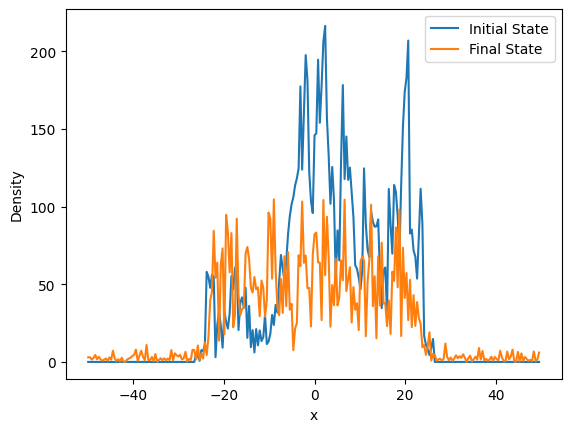

In [45]:
plt.figure() 
plt.plot(g_2.xi[0][0], np.abs(g_2.snaps[0])[len(g_2.snaps[0])//2]**2, label = 'Initial State')
plt.plot(g_2.xi[0][0], np.abs(g_2.snaps[-1])[len(g_2.snaps[-1])//2]**2, label = 'Final State')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()

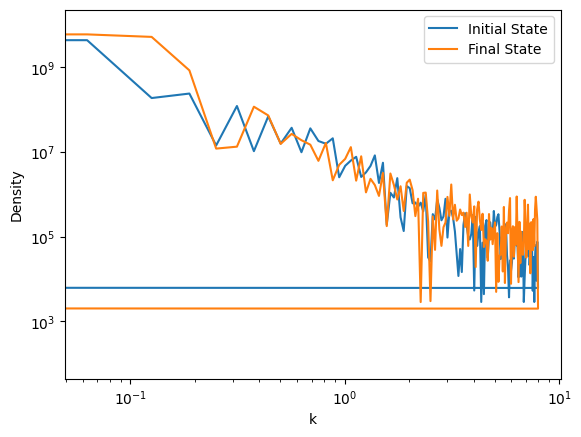

In [46]:
plt.figure() 
plt.plot(g_2.ki[0][0], np.abs(fft2(g_2.snaps[0]))[0]**2, label = 'Initial State')
plt.plot(g_2.ki[0][0], np.abs(fft2(g_2.snaps[-1]))[0]**2, label = 'Final State')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Density')
plt.legend() 